# EDA

In [137]:
import sys
import importlib
from os import listdir

from collections import defaultdict
import numpy as np
import pandas as pd
import pylab as plt
# import matplotlib as plt
%matplotlib inline
import SimpleITK as sitk

from scripts.patient import Patient
from scripts import read_scans_utils

In [134]:

importlib.reload(sys.modules["scripts.patient"])
importlib.reload(sys.modules["scripts.read_scans_utils"])
from scripts.patient import Patient
from scripts import read_scans_utils

In [44]:
# The amount of patients available
files = [f for f in listdir("Scans")]
print(len(files))


170


### Taking a look at imaging data for a patient

In [33]:
# Read sample patient
patient7 = read_scans_utils.read_patient("MARPROC007_nii")


['1101_tdce-25.nii', '3502_tdce-25_ktrans_tofts_popaif_parker_fixedt1.nii', '3503_tdce-25_kep_tofts_popaif_parker_fixedt1.nii', '3505_tdce-25_ve_tofts_popaif_parker_fixedt1.nii', '401_st2_tse.nii', '501_tt2_tse.nii', '601_ct2_tse.nii', '802_dtadc.nii', '899_tdwi_ssepi_801__20140825_adc.nii', '899_tdwi_ssepi_801__20140825_perffrac.nii', 'DWI_0.nii', 'DWI_200.nii', 'DWI_800.nii']


(512, 512, 30)


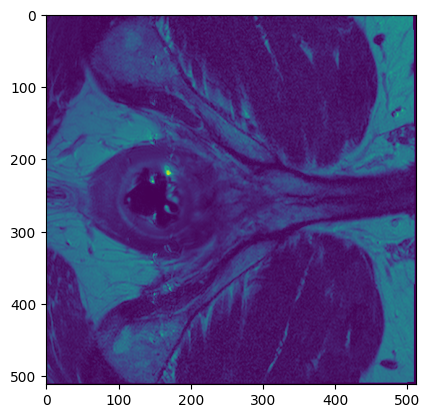

In [58]:
# Extract & plot an axial T2 image
axialt2_p7 = patient7.axialt2

# Print the shape of the image
# x, y, z, where x, y is the resolution of a single slice of the 3d image, and z the amount of slices
print(np.asanyarray(axialt2_p7.dataobj).shape)
# print the first slice in the image
plt.imshow(np.asanyarray(axialt2_p7.dataobj)[:, :, 0])

(176, 176, 20)


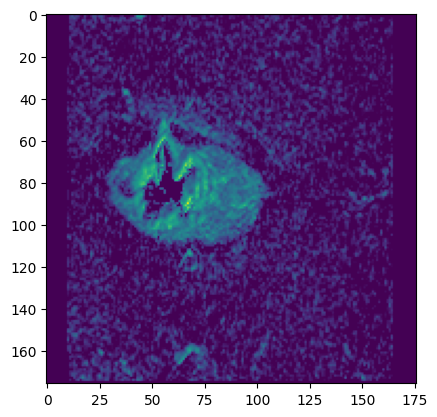

In [45]:
adcmap_p7 = patient7.adcmap

# ADC maps have a different resolution, and a different amount of slices per patient
# For use in the training of a model, they will need to be resized to a common size
print(np.asanyarray(adcmap_p7.dataobj).shape)

# Plot adcmap image
plt.imshow(np.asanyarray(adcmap_p7.dataobj[:, :, 0]))

(176, 176, 20)


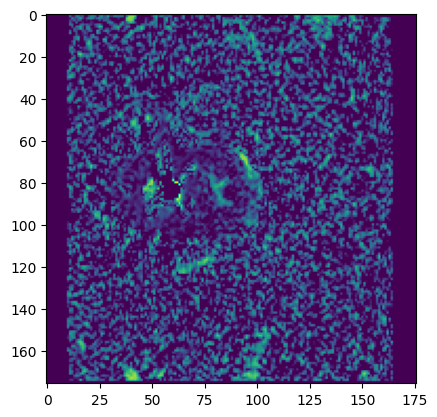

In [53]:
perffrac_p7 = patient7.perfusionmap

# Perfusion maps have the same resolution as ADC maps
print(np.asanyarray(perffrac_p7.dataobj).shape)

# Plot a perfusionmap image
plt.imshow(np.asanyarray(perffrac_p7.dataobj[:, :, 0]))

In [52]:
# Each of the images are .nii or NifTi files, meaning they carry alot more metadata next to the actual imaging data
print(patient7.axialt2)
# print(patient7.adcmap)
# print(patient7.perfusionmap)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (512, 512, 30)
affine:
[[-2.72656471e-01 -1.48925167e-02  1.56984076e-01  7.84771729e+01]
 [-1.49605758e-02  2.73026407e-01 -1.00043723e-02 -4.59993896e+01]
 [ 1.42372679e-02  1.69210962e-03  2.99587297e+00 -2.53421497e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 512 512  30   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         0.2734375  0.2734375  2.9999998  1.         1.
  1.         1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal

### Checking consistency across the whole set

First, the entire set will have to be read

In [65]:
# The amount of files (patients)
print(len(files))

170


In [128]:
patients = defaultdict()

for file in files:
    patient = read_scans_utils.read_patient(file)
    if patient != None:
        patients[file] = patient 

print("Amount of patient successfully read:")
print(len(patients))

 

Couldnt find axialt2
MARPROC090_nii
['201_t2_tse_cor.nii', '301_t2_tse.nii']
###############

Couldnt find axialt2
MARPROC144_nii
['301_s_t2_tse.nii', '501_c_t2_tse.nii']
###############

Couldnt find axialt2
MARPROC373_nii
['301_s_t2_tse.nii', '501_c_t2_tse.nii']
###############

Couldnt find axialt2
MARPROC415_nii
['401_t2_tse.nii', '601_ct2_tse.nii']
###############

Couldnt find axialt2
MARPROC422_nii
['201_t2_tse_cor.nii', '301_t2_tse.nii']
###############

Amount of patient successfully read:
165


Now to investigate how the resolutions of imaging differ between different patients the distribution of resolutions will be examined

In [136]:
t2_resolutions = defaultdict(int)
adc_resolutions = defaultdict(int)
perf_resolutions = defaultdict(int)

for patient_id in patients:
    patient = patients[patient_id]

    t2_resolutions[np.asarray(patient.axialt2.dataobj).shape] += 1

    adc_resolutions[np.asarray(patient.adcmap.dataobj).shape] += 1

    perf_resolutions[np.asarray(patient.perfusionmap.dataobj).shape] += 1

    

df1 = pd.DataFrame(t2_resolutions.items(), columns = ["Resolution", "Occurrences"]).sort_values("Occurrences", ascending = False)
df2 = pd.DataFrame(adc_resolutions.items(), columns = ["Resolution", "Occurrences"]).sort_values("Occurrences", ascending = False)
df3 = pd.DataFrame(perf_resolutions.items(), columns = ["Resolution", "Occurrences"]).sort_values("Occurrences", ascending = False)

read_scans_utils.display_side_by_side(df1, df2, df3)

# display(df)

,Resolution,Occurrences
0,"(512, 512, 30)",57
2,"(720, 720, 30)",50
8,"(704, 704, 25)",24
5,"(704, 704, 30)",17
3,"(720, 720, 32)",4
10,"(720, 720, 35)",3
7,"(704, 704, 28)",2
1,"(720, 720, 40)",1
4,"(512, 512, 29)",1
6,"(576, 576, 30)",1


Most of the scans have a consistent resolution, with slight variation in a part of the data.
There are however some variations in either the resolution, the amount of slices, or both.\
Also important to note, is that the perfusion scans and adc scans overlap in their resolutions and slice amounts exactly, meaning the only thing that remains for scaling them for use in the network is to match them to their accompanying T2w scans together.

(176, 176)


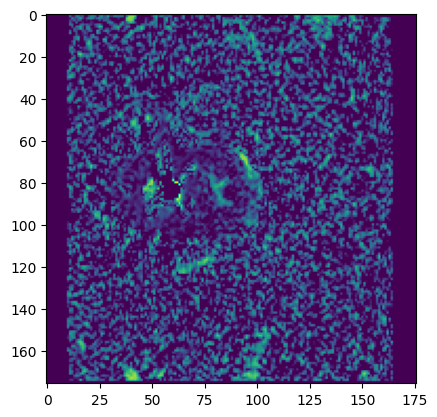

In [147]:
plt.imshow(np.asanyarray(perffrac_p7.dataobj[:, :, 0]))
print(np.asanyarray(perffrac_p7.dataobj[:, :, 0]).shape)


In [165]:
img_perf = sitk.GetImageFromArray(np.asanyarray(perffrac_p7.dataobj))
img_adc = sitk.GetImageFromArray(np.asanyarray(adcmap_p7.dataobj))
# img_perf.GetSize()
# img_perf.GetDepth()

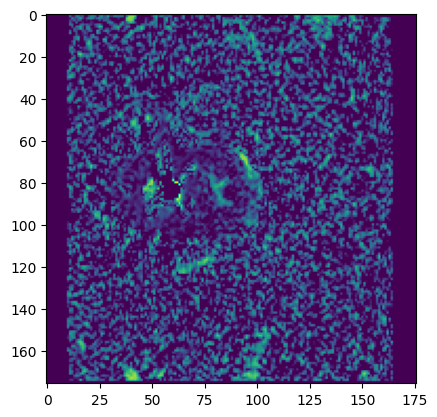

In [150]:
z = 0
slice = sitk.GetArrayViewFromImage(img)[:, :, z]
plt.imshow(slice)

In [152]:
def myshow(img):
    nda = sitk.GetArrayViewFromImage(img)
    plt.imshow(nda)



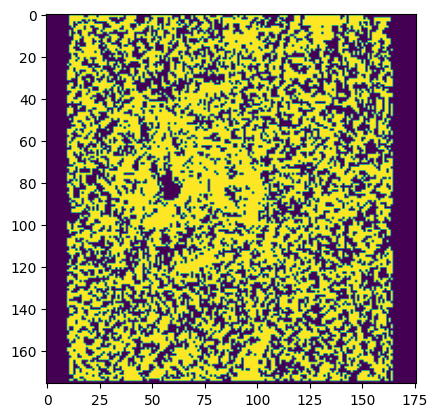

In [168]:
# I have no idea what this does
myshow(img_perf[0, :, :] > 0)

### Possible image blending
simpleitk also contains functionality to blend segmentations with images (or contours of segmentations)

In [170]:
def mask_image_multiply(mask, image):
    components_per_pixel = image.GetNumberOfComponentsPerPixel()
    if components_per_pixel == 1:
        return mask * image
    else:
        return sitk.Compose(
            [
                mask * sitk.VectorIndexSelectionCast(image, channel)
                for channel in range(components_per_pixel)
            ]
        )


def alpha_blend(image1, image2, alpha=0.5, mask1=None, mask2=None):
    """
    Alaph blend two images, pixels can be scalars or vectors.
    The alpha blending factor can be either a scalar or an image whose
    pixel type is sitkFloat32 and values are in [0,1].
    The region that is alpha blended is controled by the given masks.
    """

    if not mask1:
        mask1 = sitk.Image(image1.GetSize(), sitk.sitkFloat32) + 1.0
        mask1.CopyInformation(image1)
    else:
        mask1 = sitk.Cast(mask1, sitk.sitkFloat32)
    if not mask2:
        mask2 = sitk.Image(image2.GetSize(), sitk.sitkFloat32) + 1
        mask2.CopyInformation(image2)
    else:
        mask2 = sitk.Cast(mask2, sitk.sitkFloat32)
    # if we received a scalar, convert it to an image
    if type(alpha) != sitk.SimpleITK.Image:
        alpha = sitk.Image(image1.GetSize(), sitk.sitkFloat32) + alpha
        alpha.CopyInformation(image1)
    components_per_pixel = image1.GetNumberOfComponentsPerPixel()
    if components_per_pixel > 1:
        img1 = sitk.Cast(image1, sitk.sitkVectorFloat32)
        img2 = sitk.Cast(image2, sitk.sitkVectorFloat32)
    else:
        img1 = sitk.Cast(image1, sitk.sitkFloat32)
        img2 = sitk.Cast(image2, sitk.sitkFloat32)

    intersection_mask = mask1 * mask2

    intersection_image = mask_image_multiply(
        alpha * intersection_mask, img1
    ) + mask_image_multiply((1 - alpha) * intersection_mask, img2)
    return (
        intersection_image
        + mask_image_multiply(mask2 - intersection_mask, img2)
        + mask_image_multiply(mask1 - intersection_mask, img1)
    )

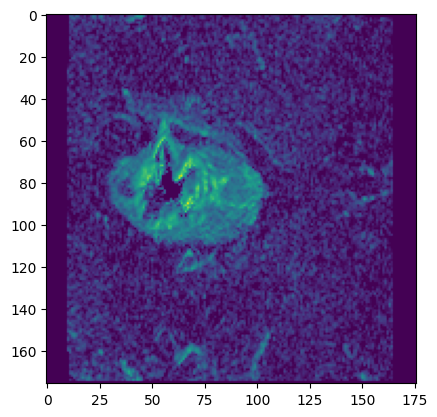

In [181]:
blend = (alpha_blend(img_perf, img_adc), "alpha_blend_standard")

myshow(blend[0][0, :, :])


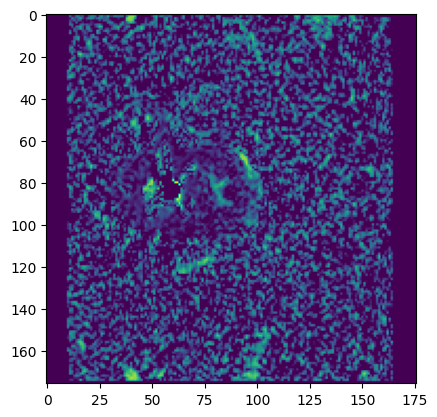

In [187]:
myshow(img_perf[0, :, :])

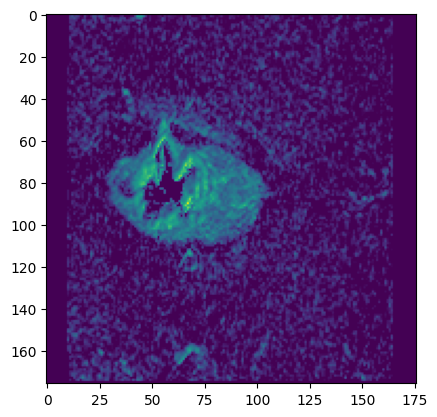

In [186]:
myshow(img_adc[0, :, :])
